In [148]:
# --- Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from prophet.plot import plot_plotly
from sklearn.metrics import mean_absolute_error, mean_squared_error


from google.colab import files
uploaded = files.upload()

Saving Superstore.csv to Superstore (2).csv


In [149]:
import chardet
with open('Superstore.csv', 'rb') as f:
    result = chardet.detect(f.read(100000))
df = pd.read_csv('Superstore.csv', encoding=result['encoding'])


In [150]:
def preprocess(df):
    df = df.drop(columns=['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID',
                          'Customer Name', 'Segment', 'Country', 'City', 'State',
                          'Postal Code', 'Region', 'Product ID', 'Category',
                          'Sub-Category', 'Product Name'])
    df = df.drop_duplicates()
    df['Order Date'] = pd.to_datetime(df['Order Date'])
    return df

df = preprocess(df)

In [151]:
# --- Time Features ---
df.set_index('Order Date', inplace=True)
df['YearMonth'] = df.index.to_period('M').astype(str)
df.reset_index(inplace=True)

# --- Monthly Aggregates ---
monthly = df.groupby(pd.Grouper(key='Order Date', freq='M')).agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Quantity': 'sum',
    'Discount': 'mean'
}).reset_index()

/tmp/ipython-input-716325071.py:7: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



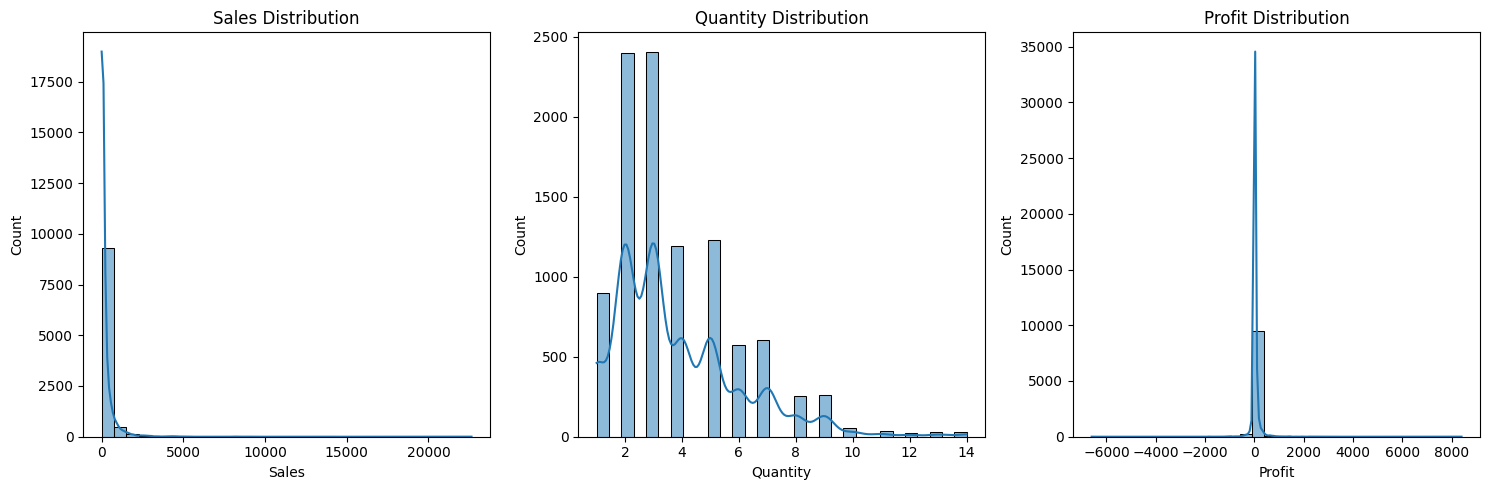

/tmp/ipython-input-1163602932.py:20: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



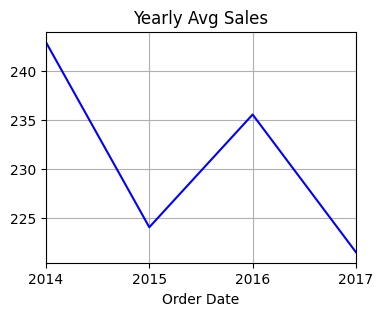

/tmp/ipython-input-1163602932.py:20: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



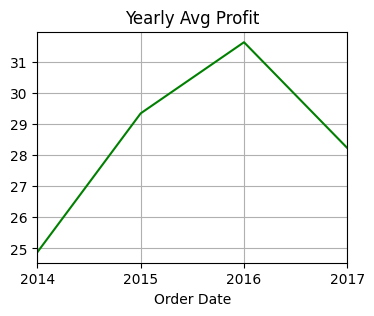

/tmp/ipython-input-1163602932.py:20: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



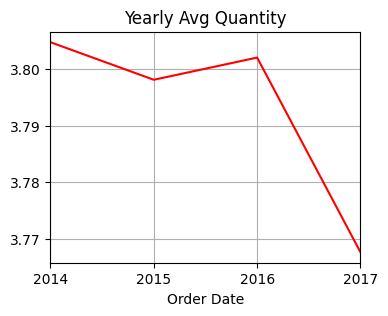

/tmp/ipython-input-1163602932.py:20: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



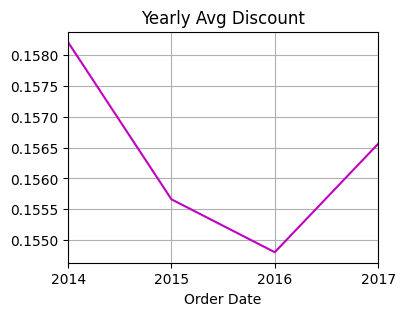

In [152]:
# --- Distributions ---
def plot_distributions(df):
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(['Sales', 'Quantity', 'Profit']):
        plt.subplot(1, 3, i+1)
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f'{col} Distribution')
    plt.tight_layout()
    plt.show()

plot_distributions(df)

# --- Scatter Plot ---
px.scatter(df, x='Sales', y='Profit', color='Sales', size='Discount',
           title='Sales vs Profit').show()

# --- Yearly Trends ---
df.set_index('Order Date', inplace=True)
for metric, color in zip(['Sales', 'Profit', 'Quantity', 'Discount'], ['b', 'g', 'r', 'm']):
    df[metric].resample('Y').mean().plot(figsize=(4, 3), color=color, title=f'Yearly Avg {metric}')
    plt.grid(True)
    plt.show()

In [194]:
monthly_prophet = monthly[['Order Date', 'Sales','Discount']].rename(columns={'Order Date': 'ds', 'Sales': 'y'})
monthly_prophet['ds'] = pd.to_datetime(monthly_prophet['ds'])

# Train-test split
cutoff = monthly_prophet['ds'].max() - pd.DateOffset(months=12)
train_df = monthly_prophet[monthly_prophet['ds'] <= cutoff]
test_df = monthly_prophet[monthly_prophet['ds'] > cutoff]


In [195]:
train_df.head()

,ds,y,Discount
0,2014-01-31,14236.895,0.126582
1,2014-02-28,4519.892,0.176087
2,2014-03-31,55691.009,0.167516
3,2014-04-30,28013.973,0.108582
4,2014-05-31,23648.287,0.155328


In [227]:
model = Prophet(
    yearly_seasonality=True,
)
model.add_regressor('Discount')
model.add_country_holidays(country_name='US')
model.fit(train_df)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1xfku53/vtbzugrb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd1xfku53/in2npf48.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88940', 'data', 'file=/tmp/tmpd1xfku53/vtbzugrb.json', 'init=/tmp/tmpd1xfku53/in2npf48.json', 'output', 'file=/tmp/tmpd1xfku53/prophet_model0uedfzy4/prophet_model-20250807084100.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:41:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:41:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [228]:
# Predict future
future = model.make_future_dataframe(periods=12, freq='M')
future = future.merge(monthly_prophet[['ds', 'Discount']], on='ds', how='left')
future['Discount'].fillna(method='ffill', inplace=True)
forecast = model.predict(future)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/tmp/ipython-input-3422061837.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipython-input-3422061837.py:4: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



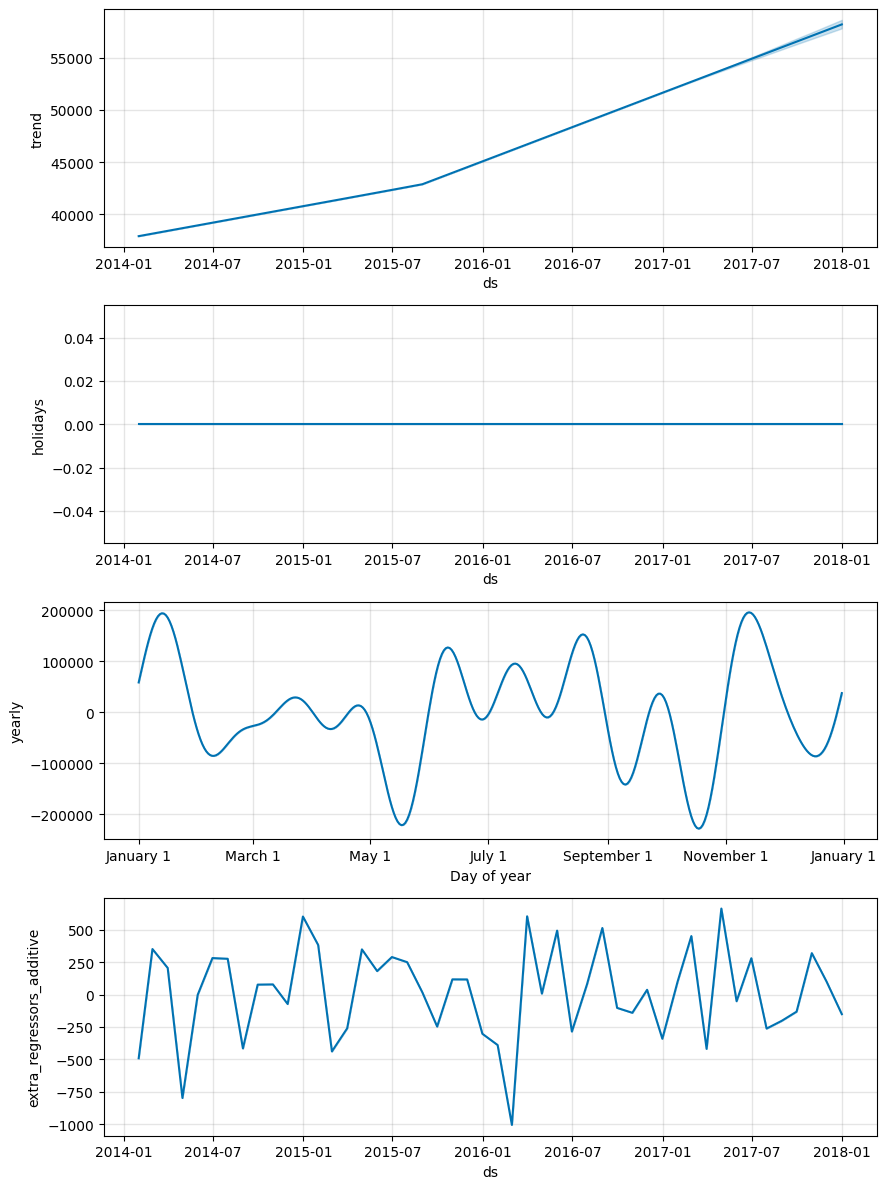

In [229]:
# Forecast components
model.plot_components(forecast)
plt.show()


In [230]:
# Forecast visualization
fig_forecast = plot_plotly(model, forecast)
fig_forecast.update_layout(title='Prophet Forecast', xaxis_title='Date', yaxis_title='Sales')
fig_forecast.show()

In [231]:
# Evaluation
merged = test_df.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
mape = np.mean(np.abs((merged['y'] - merged['yhat']) / merged['y'])) * 100

print("\n--- Model Performance ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


--- Model Performance ---
MAE: 11596.87
RMSE: 14969.49
MAPE: 19.50%


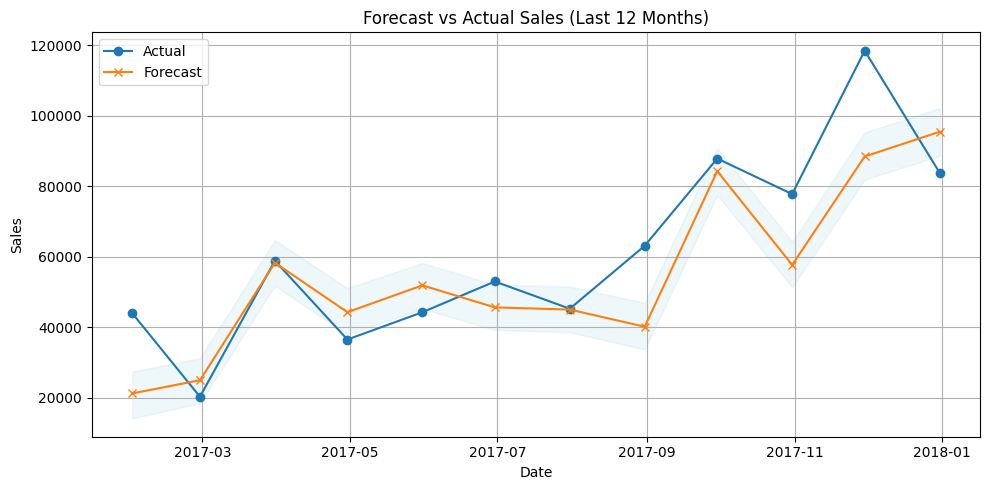

In [232]:
# Forecast vs Actual
plt.figure(figsize=(10, 5))
plt.plot(merged['ds'], merged['y'], label='Actual', marker='o')
plt.plot(merged['ds'], merged['yhat'], label='Forecast', marker='x')
plt.fill_between(merged['ds'], merged['yhat_lower'], merged['yhat_upper'], alpha=0.2, color='lightblue')
plt.title('Forecast vs Actual Sales (Last 12 Months)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()